In [2]:
import numpy as np

from scipy import ndimage
from PIL import Image
import dlib
import cv2

from sklearn.decomposition import PCA
from skimage import feature

from matplotlib import pyplot as plt

import glob,os

In [3]:
def preprocesing_images(path_="dataset"):
    """
    getting file names of all images from folder 'path_'
    Arguments:
    path_ -- path to folder with dataset, default value='dataset'

    Return:
    files -- list of file names
    """
    path_="dataset/*/*.pgm"
    files=glob.glob(path_)
    return files

photo size: (112, 92)
Image sample:


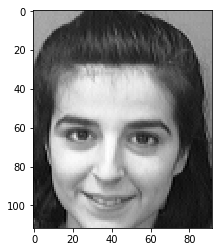

In [4]:
#getting file names of all images in folder "dataset"
files= preprocesing_images(path_="dataset")
sample=files[10]
img=np.array(Image.open(sample))
print(f'photo size: {img.shape}')
print('Image sample:')
plt.imshow(img, cmap='gray')

In [5]:
# set parametrs for model
rows=len(files)
height=img.shape[0]
width=img.shape[1]
columns=height*width

In [6]:
def create_data_matrix(files,rows,columns):
    """
    This method vectorizes images and creates matrix with shape (rows,columns).
    Where 'rows' - number of images and 'columns' - number of features (features=image height * image width)
    
    Arguments:
    files -- list of file names
    rows -- number of images
    columns -- number of features
    
    """
    row=0
    labels=[]
    data=np.zeros((rows,columns))
    for f in files:
        im=np.array(Image.open(f))
        im=im.reshape(1,im.shape[0]*im.shape[1])
   
        #create dataset: "data"
        data[row,:]=im
        row+=1
   
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [7]:
#creating dataset from images: data and labels
data, labels = create_data_matrix(files,rows,columns)
print(f'Dataset shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Dataset shape: (400, 10304)
Labels shape: (400, 1)


In [8]:
def vec_to_image(v,w=(height,width)):
    """
    Convert image vector into image array
    
    Arguments:
    v -- image vector
    w -- array size for reshaping [height, width]
    
    Return:
    img -- converted vector into array
    
    """
    img=v.reshape(w[0],w[1])
    return img

def show_image(ind,data,labels,size=(height,width)):
    """
    Show image and label from dataset.
    
    Arguments:
    ind -- index of image in dataset
    data -- matrix of dataset
    labels -- labels of images from dataset
    size -- pixel size of image.
    """
    img=vec_to_image(data[ind],size)
    plt.imshow(img, cmap='gray')
    plt.title(f'label: {np.squeeze(labels)[ind]}')

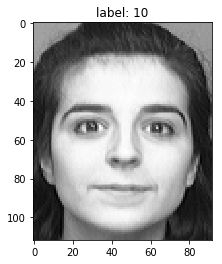

In [9]:
#test, select and show photo with index=11
index=11
show_image(index,data,labels)

In [10]:
def select_index(ind1, ind2):
    """
    selct ind1 and ind2 images from each employee
    Arguments:
    
    ind1 -- index first image for each employee
    ind2 -- index second image for each employee
    
    Return:
    test_index -- indices for test dataset, where we have 80 images (2 images for each employee * 40 employee)
    
    """
    ind1=ind1-1 #for correct indexing in array, where first element has index 0
    ind2=ind2-1
    ind1=[i+10 for i in range(ind1-10,390,10)]
    ind2=[i+10 for i in range(ind2-10,390,10)]
    test_index=np.concatenate((ind1,ind2))
    return test_index

In [11]:
def split_dataset(data,ind1=9, ind2=10):
    """
    Split data to train and test.
    Arguments:
    data -- dataset matrix
    ind1, ind2 -- index for selection test dataset
    
    Return:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    
    """
    #create indices for test dataset
    index=select_index(ind1, ind2)
    
    #create test dataset
    test_set=data[index,:]
    test_labels=labels[index]
    
    #create train data_set
    train_set=np.delete(data,index,axis=0)
    train_labels=np.delete(labels,index)
    train_labels=train_labels.reshape(len(train_labels),1)
    
    return train_set, train_labels, test_set, test_labels 

In [12]:
# split data to train and test
train_set, train_labels, test_set, test_labels = split_dataset(data)
print(f'Train set shape: {train_set.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_set.shape}, test labels shape: {test_labels.shape}')
train_orginal=train_set
test_original=test_set

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


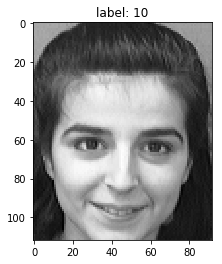

In [13]:
show_image(10,train_set,train_labels)

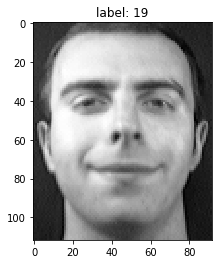

In [14]:
show_image(10,test_set,test_labels)

In [15]:
# load unknown photos and identify employee
def identify_employee(train_set,unknown_set):
    """
    This method use MSE algorithm and identify employee.
    
    Arguments:
    train_set -- train dataset
    unknown_set -- vectorized photos that we have to recognize (test data set)
    
    Returns:
    predict_index -- vector of indices, that predict labels of test dataset images
    """
    min_dist=[]
    for ind in range(unknown_set.shape[0]):
        dist=np.linalg.norm(train_set-unknown_set[ind,:],axis=1,keepdims=True)
        min_dist.append(np.argmin(dist))
    predict_index=np.array(min_dist).reshape(len(min_dist),1)
    return predict_index

def accuracy(train_labels,test_labels, predict_index, index=1):
    """
    Calculate accuracy.
    
    Arguments:
    train_label -- labels for train dataset
    test_labels -- labels for test dataset
    predict_index -- vector of indices, that predict labels of test dataset images
    index -- it uses for distinguishing usual algorithm and PCA, where accuracy receives labels insted of index
    
    Returns:
    acc -- accuracy
    err_index -- error indices
    true_index -- true indices
    """
    if index:
        yhat=np.squeeze(train_labels[predict_index])
    else:
        yhat=predict_index
    ytest=np.squeeze(test_labels)
    compare=yhat==ytest
    err_index=np.where(compare==False)
    true_index=np.where(compare==True)
    true_answ=sum(compare)
    acc = (true_answ/test_labels.shape[0])*100     
    return acc,err_index,true_index

def show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,figsize=(10,10),index=1,
                X=train_orginal,X_test=test_original):
    """
    This additional method that helps to display errors of recognition or true answers of model.
    """
    n=1
    if len(err_index[0])<=1:
        l=1
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        plt.subplot(l,2,n)
        if index==True:
            show_image(predict_index[err_index],train_set,train_labels)
        else:
            show_image(np.where(train_labels==predict_index[err_index])[0][0],train_set,train_labels)
        n+=1
        plt.subplot(l,2,n)
        show_image(err_index,test_set,test_labels)  
    else:
        err_index=np.squeeze(err_index)
        l=err_index.shape[0]
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        for i in err_index:
            plt.subplot(l,2,n)
            if index==1:
                show_image(predict_index[i],train_set,train_labels)
            elif index==2:
                show_image(np.where(train_labels==predict_index[i])[0][0],train_set,train_labels)
            elif index==3:
                show_image(predict_index[i],X,train_labels)
                           
            n+=1
            plt.subplot(l,2,n)
            if index==3:
                show_image(i,X_test,test_labels)
            else:
                show_image(i,test_set,test_labels)
            n+=1

In [16]:
def model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=True,show_correct=False,figsize=(10,10), index=1, norm=0, axis=0,
                           pca_flag=False, pca_energy=0.98,log=True, lbp_flag=False):
    
    """
    This function recognise face.
    
    Arguments:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    show_err -- flag for showing recognation errors, default value = True
    show_correct -- flag for showing samples of corect recognition, default value = False
    figsize -- figsize for displaying errors ot true answers
    index -- type of image processing for method show_erros, default value=1
    norm -- type of normalization. 1 - substract mean, 2 - standardize data, 0 - without normalization
    axis -- axis of normalization
    pca_flag -- turn on PCA
    pca_energy -- coefficient of explained bariance, default value=0.98
    log -- turn on print log
    lbp_flag -- turn on LBP
    
    Return:
    acc -- Accuracy
    """
    if lbp_flag:
        train_set=create_lbp_set(train_set)
        test_set=create_lbp_set(test_set)
    #Normalization
    if norm==1:
        train_set=subtract_mean(train_set, axis=axis)
        test_set=subtract_mean(test_set, axis=axis)
    elif norm==2:
        train_set=standard_norm(train_set, axis=axis)
        test_set=standard_norm(test_set, axis=axis)
        
        
    if pca_flag:
        if norm==0:
            print('Warning! You have to make normalization.') 
        train_set,transform_pca = my_pca(train_set,pca_energy=pca_energy,log=log)
        test_set = np.dot(transform_pca,test_set.T).T
               
    predict_index=identify_employee(train_set,test_set)
    
    acc,err_index,true_index=accuracy(train_labels,test_labels, predict_index,index=index)
    if log:
        print(f'Accuracy for test dataset = {acc}')
    #Error visualization
    if show_err:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,index=index,figsize=figsize)
    if show_correct:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,true_index,index=index,figsize=(10,90))
    return acc

Accuracy for test dataset = 96.25
Predict photo                          Real photo


96.25

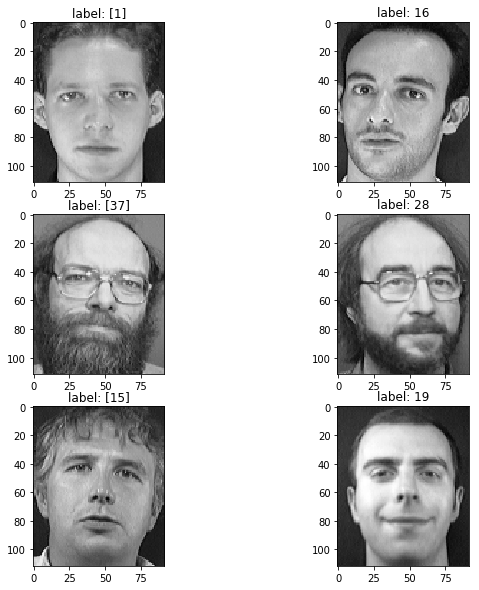

In [17]:
# Result without normalization
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True)

Accuracy for test dataset = 96.25
Predict photo                          Real photo


96.25

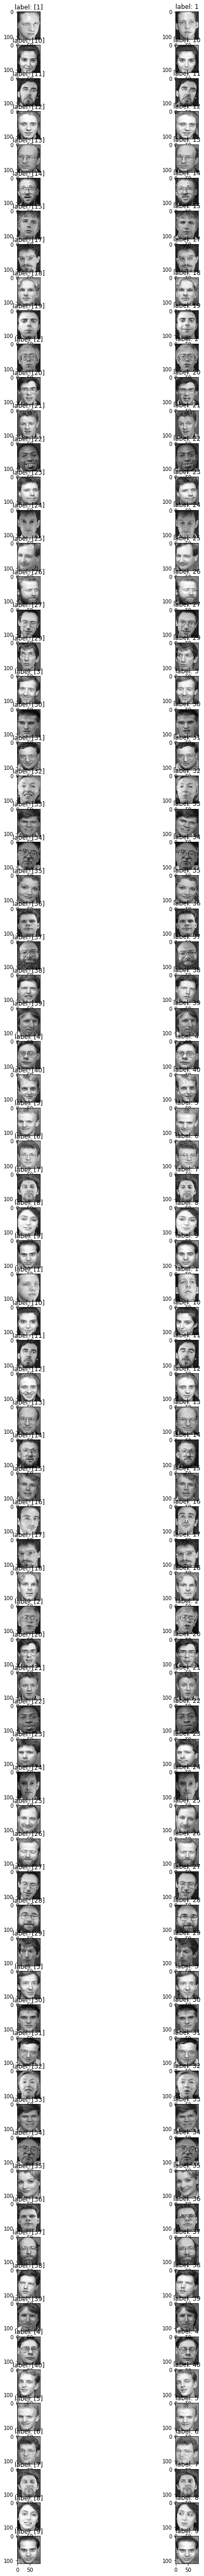

In [18]:
#demonstration how model can identify emploee
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,show_correct=True)

In [19]:
# make shuffle for train dataset and define accuracy
index_shuffle=np.arange(train_set.shape[0])
np.random.shuffle(index_shuffle)
model_face_recognition(train_set,train_labels,train_set[index_shuffle],train_labels[index_shuffle],show_err=False)

Accuracy for test dataset = 100.0


100.0

## Optimization / Normalization steps

In [20]:
#subtract mean value from the feature
def subtract_mean(x,axis=0):
    """
    Data normalizatin: x-x.mean
    Argument:
    x - matrix, dataset
    Return:
    Normalized dataset
    """
    return x-x.mean(axis=axis,keepdims=True)

# standard score: (X-mu)/sigma
def standard_norm(X,axis=0):
    """
    Data normalizatin: (x-x.mean)/s.std
    Argument:
    x - matrix, dataset
    Return:
    Normalized dataset
    """
    A=(X-X.mean(axis=1, keepdims=True))/X.std(axis=axis, keepdims=True)
    return A

In [21]:
# Accuracy for normalized dataset, method - subtract_mean
print('Normalization by features')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=1,axis=0)
print('Normalization by samples')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=1,axis=1)

Normalization by features
Accuracy for test dataset = 95.0
Normalization by samples
Accuracy for test dataset = 95.0


95.0

In [22]:
#Accuracy didn't change, after normalization through subtraction mean from each feature

In [23]:
# Accuracy for normalized dataset, method - standard score: (X-mu)/sigma
print('Normalization by features')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=2,axis=0)
print('Normalization by samples')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=2,axis=1)

Normalization by features
Accuracy for test dataset = 93.75
Normalization by samples
Accuracy for test dataset = 95.0


95.0

In [24]:
# Accuracy become worse after applying standardization of dataset

### Table of different types normalization and corresponding accuracy
| Accuracy | subtract_mean | standard_norm |
| --- | --- | --- |
| by features | 95 | 93.75 |
| by samples | 95 | 95 |

## PCA

In [25]:
def my_pca(X,pca_energy=0.98,log=False):
    """
    My own realization pca model.
    Arguments:
    X -- Dataset
    pca_energy -- If float - explained variance, for example 0.98. If int and > 1, number of komponents. If 1 - all komponents are saved
    log -- turn on print log
    Returns:
    X_pca -- matrix after decomposition
    transform_pca -- matrix for decomposition test_set
    
    """
    #buid covariance matrix
    C=np.dot(X,X.T)
    #find out eigenvalues and eigen vectors
    eig, eig_v= np.linalg.eig(C)
    # choose type of pca model: use percent of variance or number of components
    if (type(pca_energy)==float or type(pca_energy)==np.float64) and (pca_energy<1):
        n=X.shape[1]
        p=1
        i=0
        while p>pca_energy:
            i+=1
            ind=np.argsort(-eig)[:n-i]
            p=np.sum(eig[ind])/np.sum(eig)
        important_vec=eig_v[ind]  
    elif pca_energy==1:
        important_vec=eig_v 
    else:
        ind_big=np.argsort(-eig)[:int(pca_energy)]
        important_vec=eig_v[ind_big]

    W=np.dot(important_vec,X)
    #Projecting all training samples into the PCA subspace.
    X_pca=np.dot(W,X.T)
    if log:
        print(f'shape train dataset after projection into PCA subspace {X_pca.T.shape}')  
    return X_pca.T,W

In [26]:
#Normalization 'substract mean' by features
pca_energy=0.95
print("Normalization 'substract mean' by features")
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=1, axis=0,
                           pca_flag=True, pca_energy=pca_energy)

#Normalization 'substract mean' by samples
print("Normalization 'substract mean' by samples")
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=1, axis=1,
                           pca_flag=True, pca_energy=pca_energy)

#Normalization 'standard_norm' by features
print("Normalization 'standard_norm' by features")
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=2, axis=0,
                           pca_flag=True, pca_energy=pca_energy)
#Normalization 'standard_norm' by samples
print("Normalization 'standard_norm' by samples")
model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=False,show_correct=False, norm=2, axis=1,
                           pca_flag=True, pca_energy=pca_energy)

Normalization 'substract mean' by features
shape train dataset after projection into PCA subspace (320, 160)
Accuracy for test dataset = 95.0
Normalization 'substract mean' by samples
shape train dataset after projection into PCA subspace (320, 125)
Accuracy for test dataset = 88.75
Normalization 'standard_norm' by features
shape train dataset after projection into PCA subspace (320, 120)
Accuracy for test dataset = 85.0
Normalization 'standard_norm' by samples
shape train dataset after projection into PCA subspace (320, 130)
Accuracy for test dataset = 88.75


88.75

### Table accuracy for different types normalization (by features) and different values of pca_energy
| pca_energy | subtract_mean | standard_norm |
| --- | --- | --- |
| 1 | 93.75 | 86.25 |
| 0.98 | 93.75 | 85 |
| 0.95 | 95 | 85 |

### Table accuracy for different types normalization (by samples) and different values of pca_energy
| pca_energy | subtract_mean | standard_norm |
| --- | --- | --- |
| 1 | 93.75 | 88.75 |
| 0.98 | 88.75 | 85.5 |
| 0.95 | 88.75 | 88.75 |

E:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


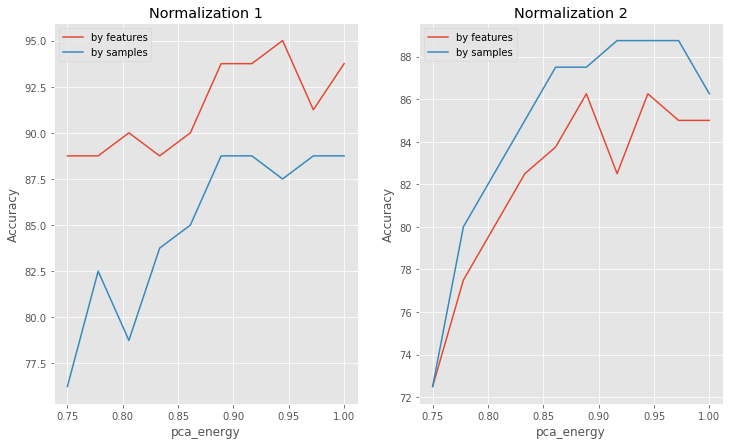

In [27]:
#Vizualization
plt.style.use('ggplot')
plt.figure(figsize=(12,7))
pca_list=np.linspace(0.75,1,10)
norm_list=[1,2]
axis=[0,1]
for n in norm_list:
    for a in axis:
        results=[]
        if a==0:
            name_axis='by features'
        else:
            name_axis='by samples'
        for p in pca_list:
            acc=model_face_recognition(train_set,train_labels,test_set,test_labels,
                                   show_err=False,show_correct=False, norm=n, axis=a,
                                   pca_flag=True, pca_energy=p,log=False)
            results.append(acc)
        plt.subplot(1,2,n)
        plt.plot(pca_list,results,label=f'{name_axis}')
        plt.title(f'Normalization {n}')
        plt.xlabel('pca_energy')
        plt.ylabel('Accuracy')
        plt.grid(1)
        plt.legend()

One of the most important applications of PCA is for speeding up machine learning algorithms.In this case 98% of the variance amount to 228 principal components.
Accuracy don't emprove and equal 93.75%

### LBP (Local Binary Pattern)

In [28]:
def calc_pattern(M,ind):
    """
     Taking the 8-bit binary neighborhood of the center pixel and converting it into a decimal representation.
     
     Arguments:
     M -- 2D array of image
     ind -- indices (row, column) of centrer pixel
    
     Return:
     lbp - decimal representation of local binear pattern
    """
    r=ind[0]
    c=ind[1]
    center=M[1,1]
    m0=M[r-1,c+1]
    m1=M[r,c+1]
    m2=M[r+1,c+1]
    m3=M[r+1,c]
    m4=M[r+1,c-1]
    m5=M[r,c-1]
    m6=M[r-1,c-1]
    m7=M[r-1,c]
    neighborhood=np.array([m0,m1,m2,m3,m4,m5,m6,m7])
    lbp=0
    for i in enumerate(neighborhood):
        if center>i[1]:
            lbp+=2**i[0]
    return lbp 

def lbt_transform(im):
    """
    Apply lbp_transformation to image
    
    Argument:
    im -- 2D array of image
    
    Return 2D array of transformed image
    """
    rows=im.shape[0]
    columns=im.shape[1]
    res=np.zeros((rows,columns))
    for r in range(1,rows-1):
        for c in range(1,columns-1):
            res[r,c]=calc_pattern(im,(r,c))
    return res

In [29]:
def create_lbp_set(data,height=112,width=92):
    """
    Apply LBP transformation for all images in dataset
    
    Arguments:
    data -- Matrix of dataset
    height -- height of image in pixels, default value = 112
    width -- width of image, default value - 92
    
    Return:
    data_lbp -- Matrix of dataset after applying LBT-transformation
    
    """
    row=0
    data_lbp=np.zeros((data.shape[0],data.shape[1]))
    for f in data:
        #create dataset: "data"
        data_lbp[row,:]=lbt_transform(f.reshape(height,width)).ravel()
        row+=1
    return data_lbp

Accuracy for test dataset = 87.5
Predict photo                          Real photo


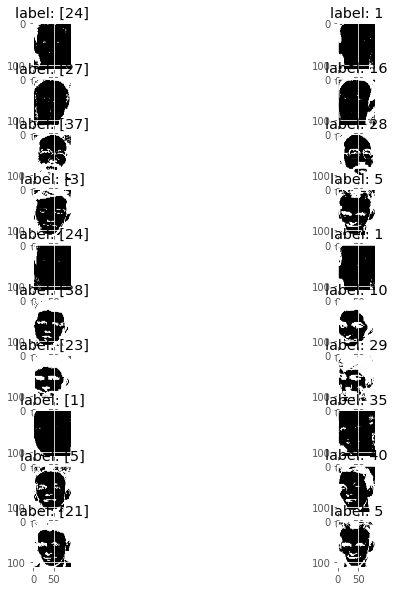

In [30]:
acc=model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=True,show_correct=False,figsize=(10,10), index=1, norm=0, axis=0,
                           pca_flag=False, pca_energy=0.98,log=True, lbp_flag=True)

We have good enough accuracy after implementation LBT algorithm. But accuracy is worse then before

## END

In [31]:
### Temporary functions


In [32]:
def create_lbp(files,height=112,width=92):
    row=0
    labels=[]
    data=np.zeros((len(files),height*width))
    for f in files:
        img=np.array(Image.open(f))
        #create dataset: "data"
        data[row,:]=lbt_transform(img).ravel()
        row+=1
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [33]:
data_lbp, labels_lbp=create_lbp(files)
print(f'dataset shape {data_lbp.shape}')
#split dataset
train_lbp, train_labels_lbp, test_set_lbp, test_labels_lbp = split_dataset(data_lbp)


dataset shape (400, 10304)


In [34]:
#Accuracy for recognition with lbt transformation
acc=model_face_recognition(train_lbp, train_labels_lbp, test_set_lbp, test_labels_lbp,
                           show_err=False,show_correct=False, index=1, norm=0,log=True)

Accuracy for test dataset = 87.5


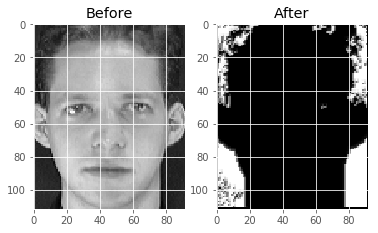

In [35]:
#let's check one example from dataset after LBT transformation
im=np.array(Image.open(files[0]))
res=lbt_transform(im)
plt.subplot(121)
plt.title('Before')
plt.imshow(im,cmap='gray')
plt.subplot(122)
plt.title('After')
plt.imshow(res,cmap='gray')